# Importation

In [5]:
from sklearn.mixture import GaussianMixture 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import toolkit as kit
import HMM as HMM
import warnings
import scipy
from scipy import stats
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import statsmodels.api as sm
from scipy.stats import kstest
from scipy import integrate
from hmmlearn import hmm


%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EDA

In [8]:
inds = kit.get_ind_30_ret()

In [39]:
inds.tail()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2023-03,0.036621,0.040662,0.001099,0.024888,-0.039677,0.050313,0.041238,0.024595,-0.035938,-0.059432,...,-0.001301,0.093399,0.094037,0.001399,-0.008234,0.006081,0.036235,0.032854,-0.090581,0.021370
2023-04,0.029170,0.040950,0.040182,0.003394,0.015480,0.042676,0.021957,0.040374,-0.002904,0.040950,...,0.009851,0.020391,-0.018775,0.000800,-0.023883,0.004490,0.017545,0.049361,0.019508,0.042485
2023-05,-0.049926,-0.028914,-0.091348,0.021761,-0.006320,-0.095520,-0.145951,-0.037390,-0.079368,-0.120700,...,-0.098716,0.072228,0.079366,-0.082512,0.002597,-0.012781,0.020587,-0.052979,-0.038429,-0.023985
2023-06,0.003793,0.027518,0.074829,0.090846,0.058835,0.069526,0.068873,0.045547,0.105980,0.114845,...,0.045260,0.042772,0.077331,0.067565,0.110020,0.109751,0.076405,0.056002,0.057042,0.064945
2023-07,0.019607,0.031886,0.014790,0.018036,0.041909,0.003295,0.010049,-0.001201,0.042868,0.034015,...,0.009752,0.045738,0.034112,0.050598,0.068593,-0.010353,0.031596,0.028101,0.062035,0.011138


My purpose of using the Industry Portfolio Monthly return is trying to catch different trend in different industry at time $t$. In this case, we fit a different Hidden Markov Model into different industry and find the absolute strength of each industry in the Black Litterman Model. The purpose of using Hidden Markov is to find positive/constant/negative trend in each industry in this phase. And the next step is to develop a mechanism to impute the active views for BL.

In [10]:
scaler = StandardScaler()
inds_std = scaler.fit_transform(inds)
inds_std = pd.DataFrame(inds_std, columns = inds.columns, index=inds.index)

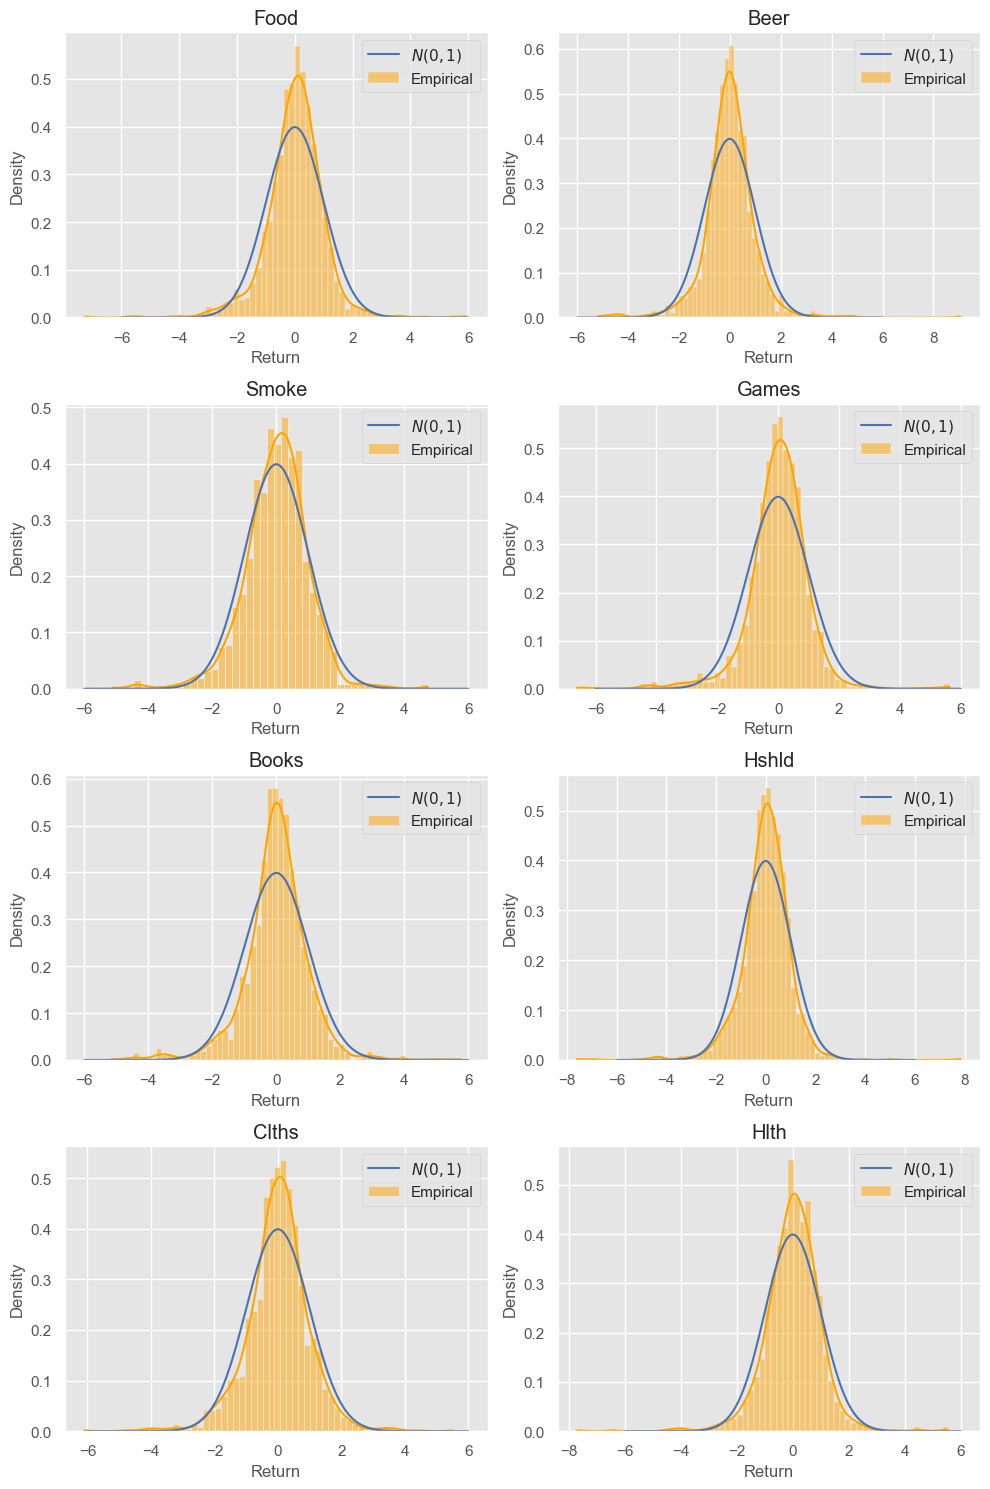

In [43]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15))  
axes = axes.flatten()

# x-axis for the normal distribution
x_axis = np.arange(-6, 6, 0.001)

# Loop through each industry and create a subplot
for i, col in enumerate(inds_std.columns[:8]):

    sns.histplot(inds_std[col], ax=axes[i], label="Empirical", kde=True, color='orange', stat='density')

    # Create the normal distribution line plot
    sns.lineplot(x=x_axis, y=norm.pdf(x_axis), ax=axes[i], label='$N(0, 1)$', color='b')

    # Set the title of the subplot
    axes[i].set_title(col)
    
    axes[i].set_xlabel('Return')
    

    # Add legend
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

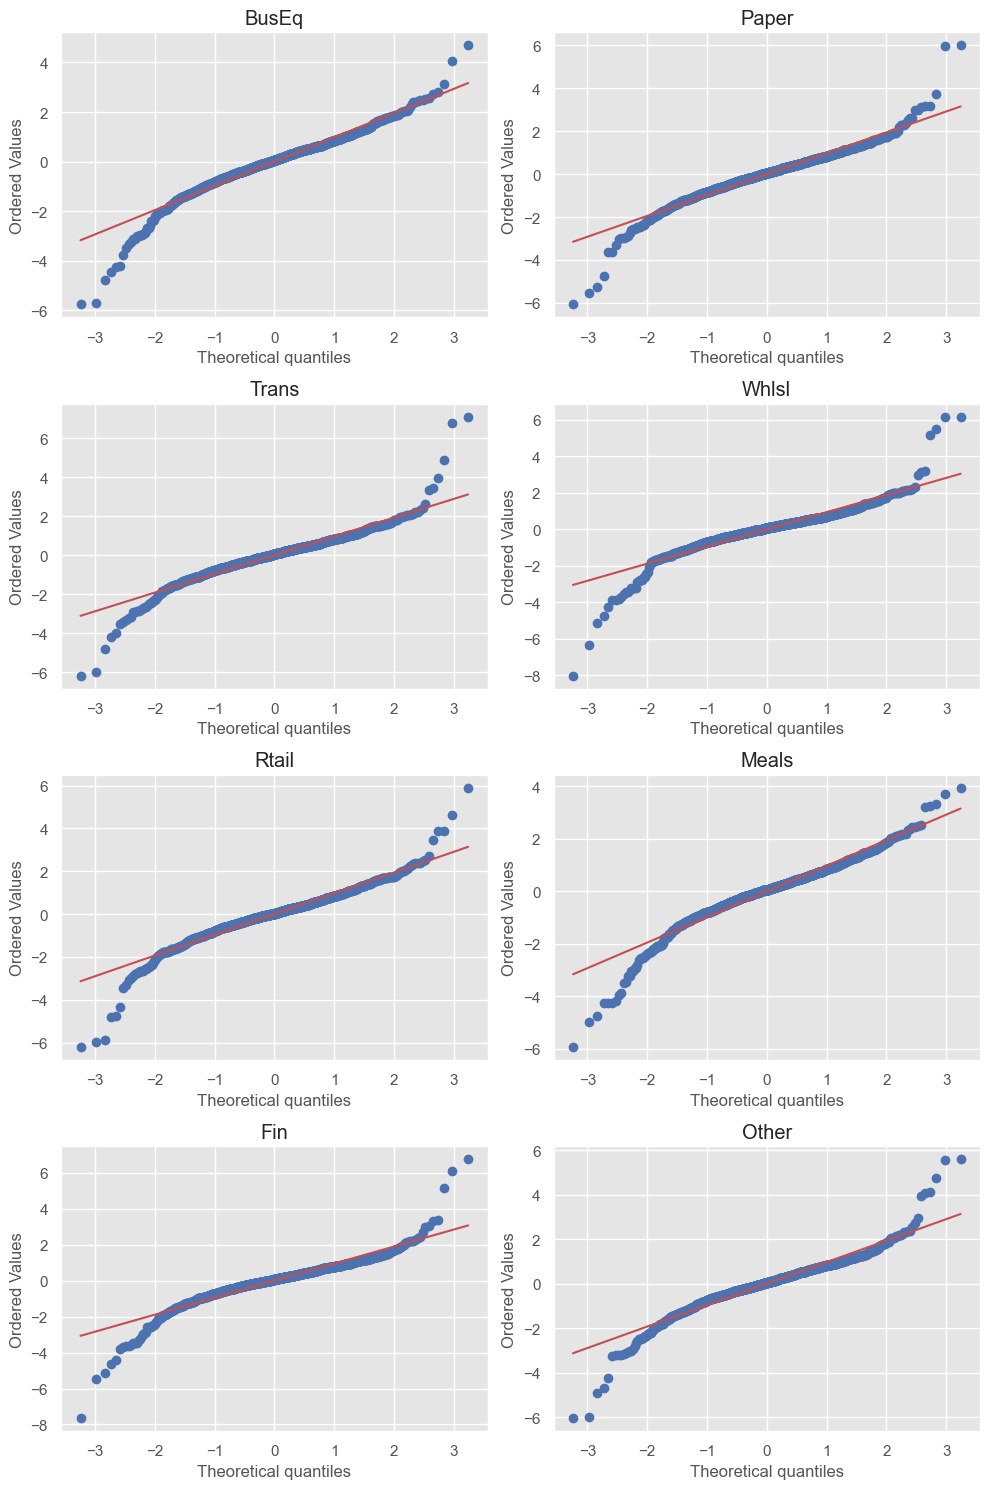

In [37]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15))  
axes = axes.flatten()

for i, col in enumerate(inds_std.columns[-8:]):

    stats.probplot(inds_std[col], dist = "norm", plot = axes[i])
    axes[i].set_title(col)


plt.tight_layout()
plt.show()

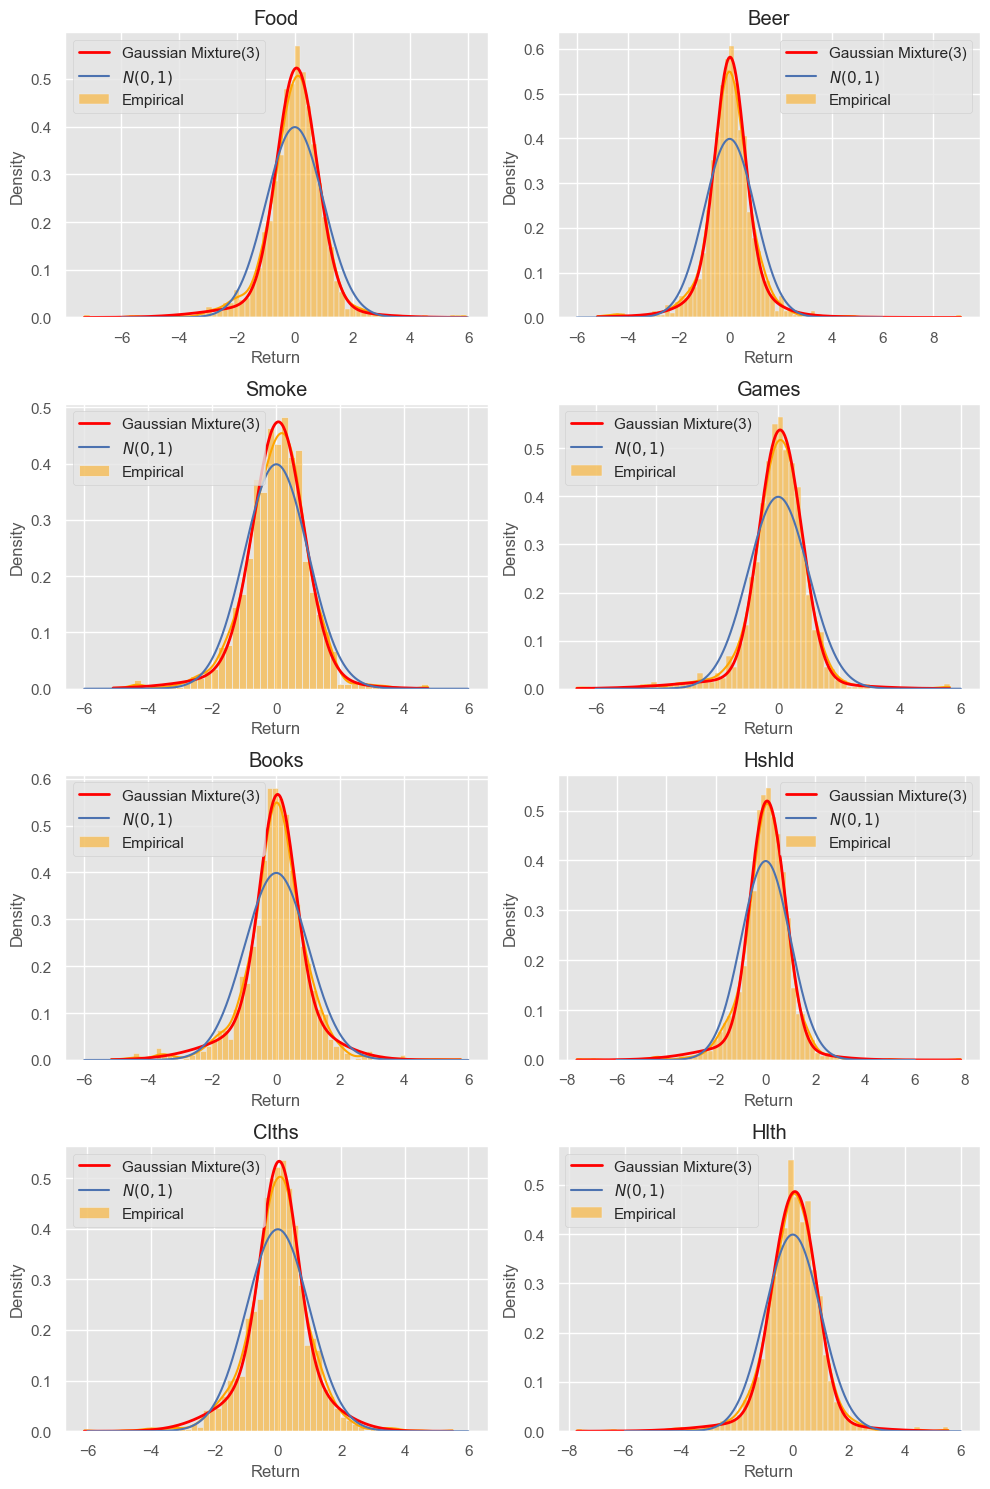

In [44]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15)) 
axes = axes.flatten()

# x-axis for the normal distribution
x_axis = np.arange(-6, 6, 0.001)

# Loop through each industry and create a subplot
for i, col in enumerate(inds_std.columns[:8]):
    gmm = GaussianMixture(n_components=3, n_init=10)

    gmm.fit(inds_std[col].array.reshape(-1, 1))
    xmin, xmax = min(inds_std[col]), max(inds_std[col])
    xx = np.linspace(xmin, xmax, 1000)
    logprob = gmm.score_samples(xx.reshape(-1, 1))
    gmm_pdf = np.exp(logprob) 

    sns.histplot(inds_std[col], ax=axes[i], label="Empirical", color='orange', stat='density', kde=True)
    sns.lineplot(x=xx, y=gmm_pdf, ax=axes[i], linewidth=2, label='Gaussian Mixture(3)', color='red')

    # Create the normal distribution line plot
    sns.lineplot(x=x_axis, y=norm.pdf(x_axis), ax=axes[i], label='$N(0, 1)$', color='b')

    # Set the title of the subplot
    axes[i].set_title(col)
    axes[i].set_xlabel('Return')
    

    # Add legend
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

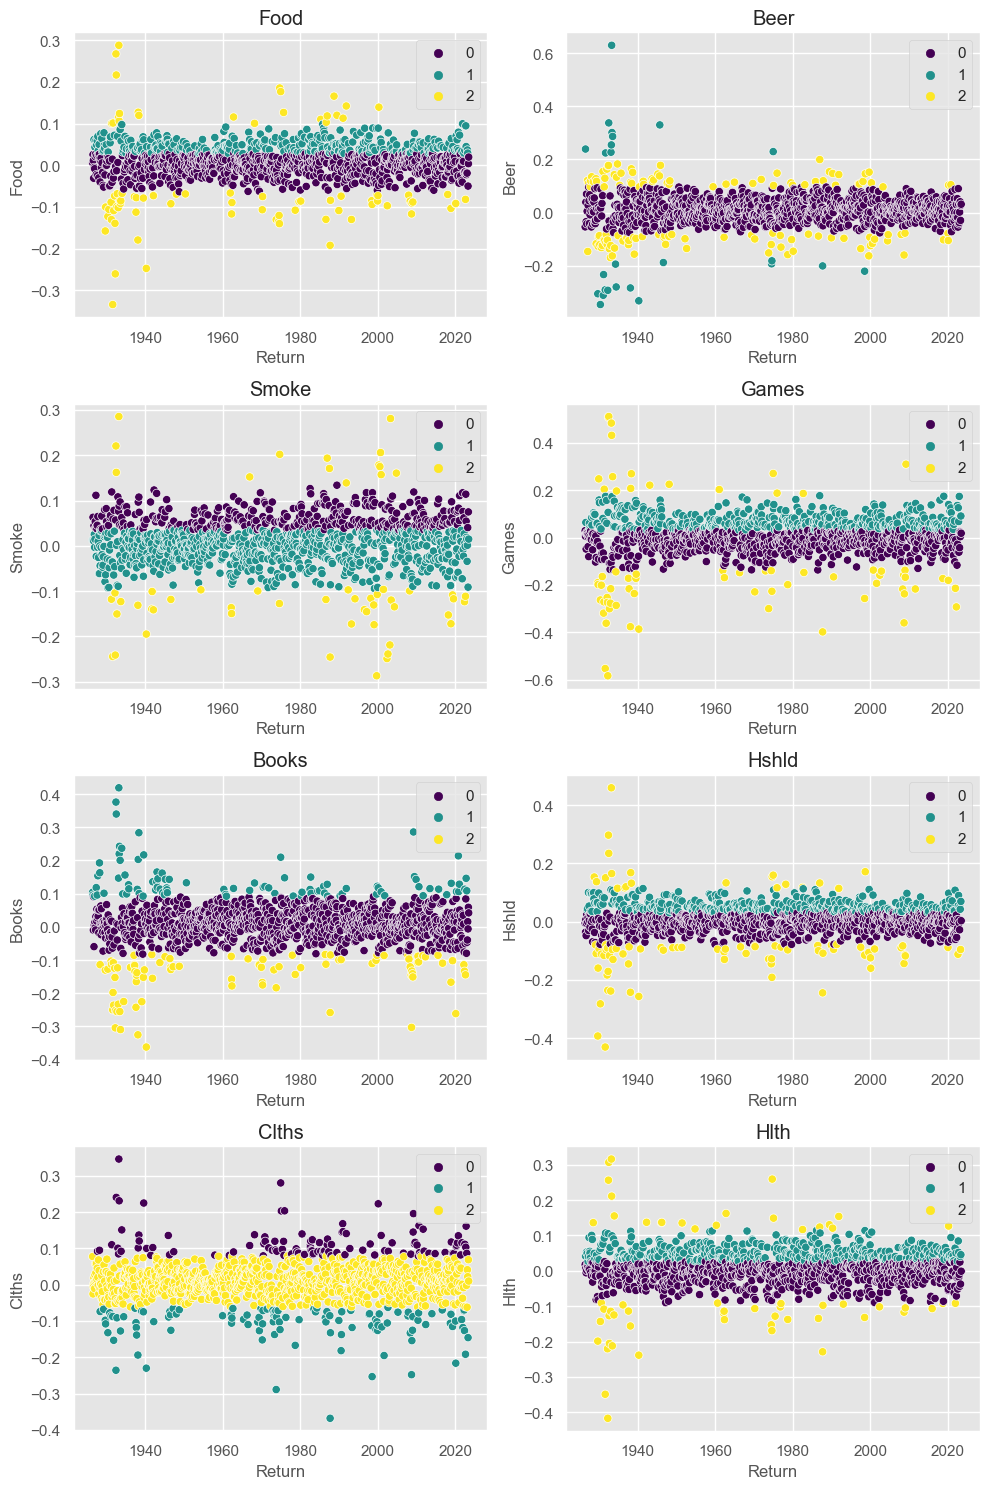

In [45]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15))  
axes = axes.flatten()

# Loop through each industry and create a subplot
for i, col in enumerate(inds.columns[:8]):
    gmm = GaussianMixture(n_components=3, n_init=10)
    states = gmm.fit_predict(inds[col].array.reshape(-1, 1))
    df = pd.DataFrame({'Time': inds.index.to_timestamp(), f'{col}': inds[col], 'State': states})
    sns.scatterplot(data=df, x='Time', y=f'{col}', hue='State', palette='viridis', ax=axes[i]) 
    axes[i].set_title(col)
    axes[i].set_xlabel('Return')

    axes[i].legend()

plt.tight_layout()

# Show the plot
plt.show()

In [3]:
# Trying Food First
food = data['Food']

In [20]:
# Check NA Values
sum(food.isna())

0

In [11]:
food.describe()

count    1165.000000
mean        0.009611
std         0.047086
min        -0.283800
25%        -0.013200
50%         0.011300
75%         0.034800
max         0.333100
Name: Food, dtype: float64

In [5]:
# Standardize the ret
food_std = stats.zscore(food) 
food_std.describe()

count    1.165000e+03
mean     6.099079e-18
std      1.000429e+00
min     -6.234072e+00
25%     -4.846676e-01
50%      3.588077e-02
75%      5.351823e-01
max      6.873125e+00
Name: Food, dtype: float64

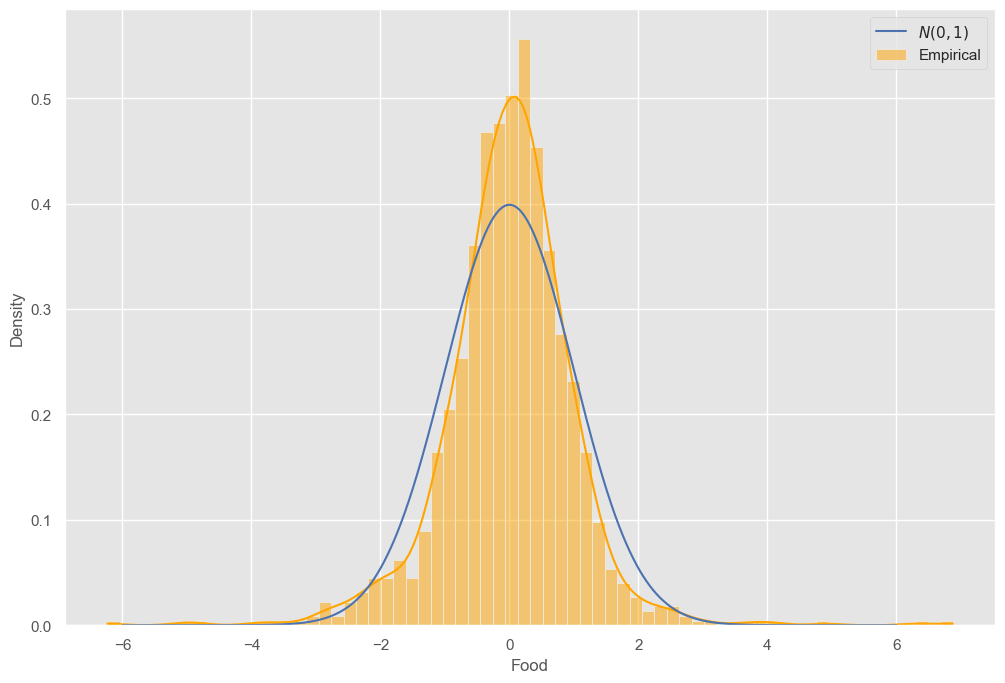

In [13]:
# Analyze the empirical density vs normal
x_axis = np.arange(-6, 6, 0.001)
sns.histplot(food_std,  label="Empirical", kde=True, color='orange', stat='density')
sns.lineplot(x=x_axis, y=norm.pdf(x_axis), label='$N(0,1)$', color = 'b')
plt.legend();

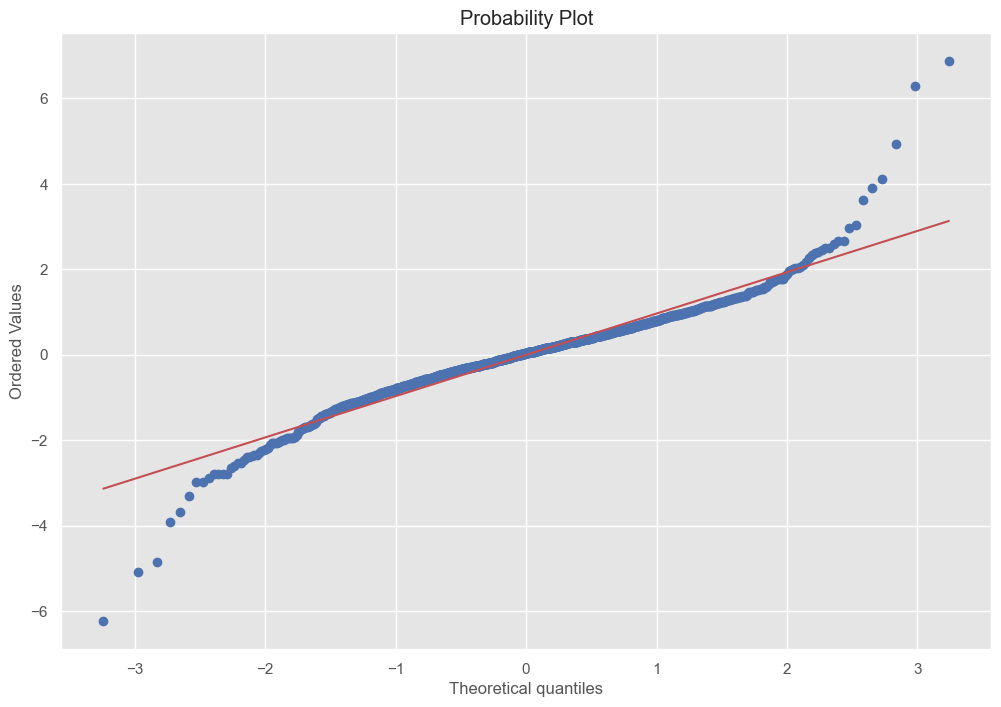

In [14]:
fig, ax = plt.subplots()
_ = stats.probplot(food_std, dist = "norm", plot = ax)

The two plots show the empirical kernel density has the leptokurtosis in the middle and fat tails especially in the negative side. The distribution for standardized monthly return deviates significantly from normal.

In [15]:
## TODO: Next fit both Gaussian mistrue 2, and 3 and check log likelihood, AIC, BIC, and Kolmogorov-Smirnov test

In [17]:
def mix_norm_cdf(x, weights, means, covars):
    mcdf = 0.0
    for i in range(len(weights)):
        mcdf += weights[i] * norm.cdf(x, loc=means[i][0], scale=np.sqrt(covars[i][0][0]))
    return mcdf

3118.252187872379
3143.554569702378
-5246.101186028663
KstestResult(statistic=0.4798283261802575, pvalue=8.483780768108464e-122, statistic_location=0.0061351489083478795, statistic_sign=1)


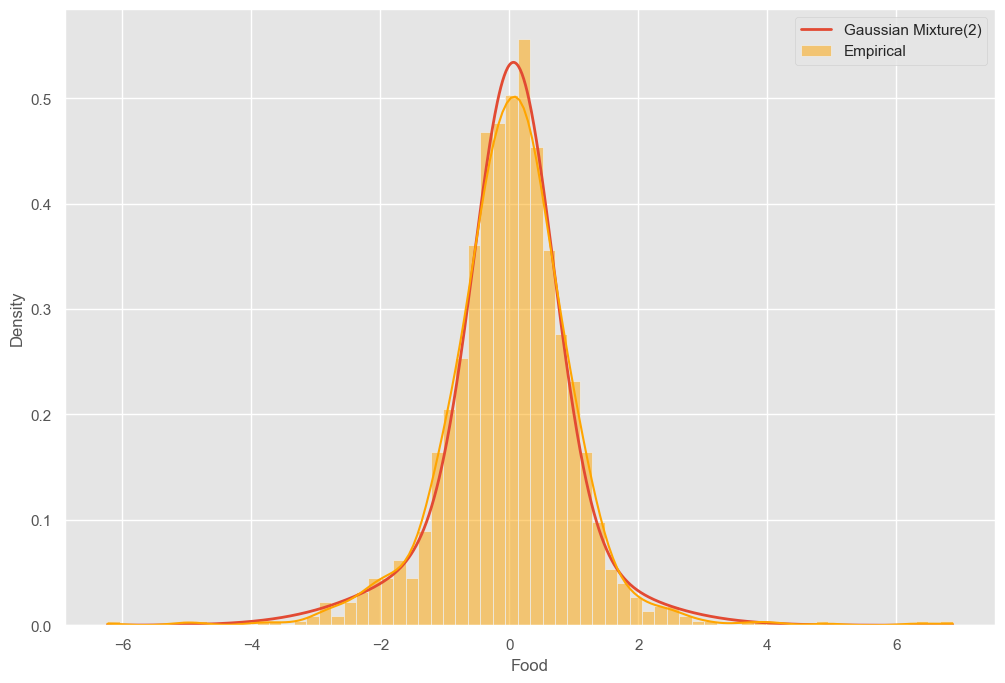

In [20]:
# Create the GMM model
gmm = GaussianMixture(n_components=2, n_init=10)
# Fit the model to the data
gmm.fit(food_std.array.reshape(-1, 1))
# Plot the PDF of the GMM
xmin, xmax = min(food_std), max (food_std)
xx = np.linspace (xmin, xmax, 1000)
logprob = gmm.score_samples(xx.reshape(-1, 1))
responsibilities = gmm.predict_proba(xx.reshape(-1, 1))
pdf = np.exp(logprob) 
plt.plot(xx, pdf, linewidth=2, label='Gaussian Mixture(2)')
sns.histplot(food_std,  label="Empirical", kde=True, color='orange', stat='density')
plt.legend()
print(gmm.aic(np.array(food_std).reshape(-1, 1)))
print(gmm.bic(np.array(food_std).reshape(-1, 1)))
print(sum(logprob))
print(kstest(np.array(food_std), mix_norm_cdf(np.array(food_std), gmm.weights_, gmm.means_, gmm.covariances_)))

3105.9334939174514
3146.41730484545
-4816.752218674598
KstestResult(statistic=0.4798283261802575, pvalue=8.483780768108464e-122, statistic_location=0.0061351489083478795, statistic_sign=1)


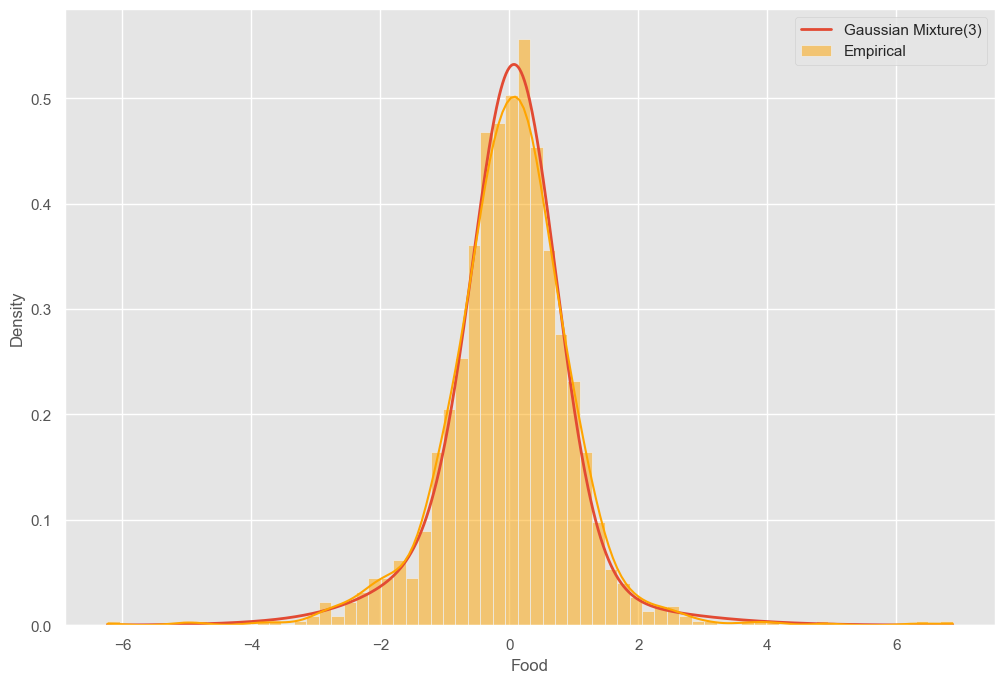

In [21]:
# Create the GMM model
gmm = GaussianMixture(n_components=3, n_init=10)
# Fit the model to the data
gmm.fit(food_std.array.reshape(-1, 1))
# Plot the PDF of the GMM
xmin, xmax = min(food_std), max (food_std)
xx = np.linspace(xmin, xmax, 1000)
logprob = gmm.score_samples(xx.reshape(-1, 1))
responsibilities = gmm.predict_proba(xx.reshape(-1, 1))
pdf = np.exp(logprob) 
plt.plot(xx, pdf, linewidth=2, label='Gaussian Mixture(3)')
sns.histplot(food_std,  label="Empirical", kde=True, color='orange', stat='density')
plt.legend()
print(gmm.aic(np.array(food_std).reshape(-1, 1)))
print(gmm.bic(np.array(food_std).reshape(-1, 1)))
print(sum(logprob))
print(kstest(np.array(food_std), mix_norm_cdf(np.array(food_std), gmm.weights_, gmm.means_, gmm.covariances_)))

We chose to use 3 elements mixture model dues to lower AIC and BIC with higher loglikelihood.

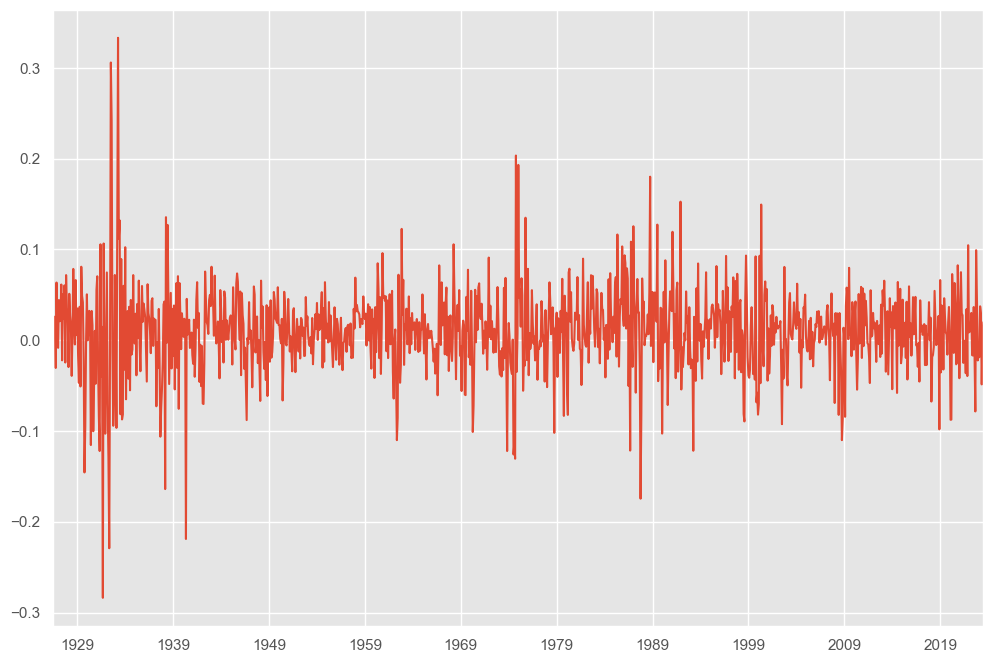

In [22]:
##Food Return
food.plot();

The graph of food industry looks like white noise, but we will use statistical test to confirm our hypothesis.

# Stationarity

Testing for stationarity is crucial in time series analysis, as many time series models assume that the data is stationary. Also, we need the data to be stationary for stronger predictive power.

The concept of stationarity is not a strict requirement for Hidden Markov Models (HMMs), but it does come into play in certain contexts and assumptions.

In the context of time series analysis, data stationarity often refers to a situation where statistical properties such as mean, variance, and autocorrelation of the data do not change over time. However, HMMs operate under a different set of principles:

1. **Markov Property**: HMMs are based on the assumption that the system being modeled follows the Markov property, meaning that the future state depends only on the current state and not on the sequence of events that preceded it.

2. **Hidden States and Observations**: HMMs consist of unobservable, or "hidden", states and observations that are visible. Each hidden state has a probability distribution over the possible output tokens, which means that the output observations are conditionally dependent on the current hidden state.

3. **Transition and Emission Probabilities**: HMMs are characterized by two key sets of probabilities: state transition probabilities (the probability of transitioning from one hidden state to another) and emission probabilities (the probability of an observation given a state). These probabilities fundamentally govern the behavior of an HMM.

Stationarity in the context of HMMs is often related to the transition probabilities between states. If these probabilities are constant over time, the system can be considered stationary. However, it's also possible to work with non-stationary HMMs where these probabilities change over time, which might be useful for modelling more complex processes that evolve.

Therefore, we need to check for stationarity for standard constant transition, emission and initial probility matrix to work for the libaray. If the assumption does not hold, we may need to preprocess the data or revise the model to adapt to the dataset.

### Augmented Dickey-Fuller (ADF) Test and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

The Augmented Dickey-Fuller (ADF) test is a commonly used statistical test that checks for the presence of unit roots in a time series sample, which would suggest non-stationarity. The ADF test is a type of unit root test that provides evidence of the stationarity of a time series, and its interpretation can be crucial for the subsequent analysis, like choosing the right model for time series forecasting.

Here's how to interpret the results of the ADF test:

1. **Null Hypothesis (H0)**: The null hypothesis of the test is that the time series contains a unit root, meaning it is non-stationary. This implies that the series has some time-dependent structure.

2. **Alternative Hypothesis (H1)**: The alternative hypothesis (rejecting the null hypothesis) is that the time series is stationary.

3. **Test Statistic**: After running the ADF test, you'll get a test statistic. The value of this statistic is compared against critical values for different confidence levels (commonly 1%, 5%, and 10%). If the test statistic is less than the critical value, then the null hypothesis is rejected.

   - If the test statistic is less negative than the critical values, then you fail to reject the null hypothesis, and the series is non-stationary.
   - If the test statistic is more negative than the critical value, then you reject the null hypothesis, and you can assume stationarity.

4. **P-value**: The p-value tells you the probability of finding the observed, or more extreme, results when the null hypothesis of a study question is true.

   - A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.
   - A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

5. **Confidence Intervals**: The test also usually provides confidence intervals for the autoregressive parameter; a value of 1 would be included in the interval if the series has a unit root.

6. **Considerations**: The ADF test has certain limitations. For instance, it has low power when the series has a near-unit root (meaning it's almost, but not quite, non-stationary), and it doesn't always differentiate well between a unit root and a series that's stationary but has some trend or structural break.

Keep in mind that while the ADF test is a powerful tool for checking the stationarity of a series, it's not infallible, and the results should be used in conjunction with empirical observations and theoretical considerations. Also, the test assumes that the time series is autoregressive, which is an assumption that might not hold for all series.

In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(food)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -8.31931400646949
p-value: 3.6084911921117305e-13


In [10]:
result

(-8.31931400646949,
 3.6084911921117305e-13,
 16,
 1148,
 {'1%': -3.4360590437486405,
  '5%': -2.864060922068716,
  '10%': -2.5681122011011426},
 -3752.9902905532235)

The test statistic is more negative than the 1% critical value and the p-value approximates to 0, we reject the null hypothesis, and we can assume stationarity.

The KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test is another method to test for stationarity in a time series. Unlike the ADF (Augmented Dickey-Fuller) test where the null hypothesis is non-stationarity, the KPSS test assumes the opposite:

1. **Null Hypothesis (H0)**: The process is trend-stationary. Trend-stationary means the series is stationary around a deterministic trend (i.e., the fluctuations around the trend are stationary).

2. **Alternative Hypothesis (H1)**: The process has a unit root, and therefore, is not stationary (i.e., the series is non-stationary due to the presence of a stochastic trend).

Here's how to interpret the results:

1. **Test Statistic**: After you perform the KPSS test, you will receive a test statistic. Just like the ADF test, you compare this statistic against a set of critical values at different confidence levels (typically 1%, 5%, and 10%).

   - If the test statistic is greater than the critical value, you reject the null hypothesis, suggesting the series is not stationary (has a unit root).
   - If the test statistic is less than the critical value, you fail to reject the null hypothesis, suggesting the series is trend-stationary (does not have a unit root).

2. **P-value**: The KPSS test also typically provides a p-value. The interpretation of the p-value in the context of the KPSS test is similar to that in other statistical tests.

   - A small p-value (typically ≤ 0.05) indicates that you should reject the null hypothesis.
   - A large p-value (> 0.05) suggests that you fail to reject the null hypothesis.

3. **Lag Length**: The KPSS test includes an aspect called "lag length" that can affect the test outcome. This is the number of lagged difference terms the test includes while testing for stationarity. Depending on the software or method used, this could be chosen automatically or may need to be set manually. The correct lag length ensures that the residuals are white noise.

The KPSS test is often used in conjunction with the ADF test because they have complementary hypotheses. The ADF test has a null hypothesis that a unit root is present, while the KPSS test has a null hypothesis that the process is trend-stationary. Using them together can provide a more comprehensive view of whether a time series is stationary.

In practical applications, if both tests agree, you can be reasonably confident in the result. If the tests disagree (i.e., ADF suggests stationarity while KPSS suggests non-stationarity, or vice versa), the series may be difference-stationary, or the tests may be influenced by the specifics of the data (e.g., structural breaks, size of the series). In such cases, further analysis or domain knowledge might be necessary to make an accurate determination.

In [12]:
from statsmodels.tsa.stattools import kpss
result = kpss(food)
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

KPSS Statistic: 0.10658135177707387
p-value: 0.1


In [13]:
result

(0.10658135177707387,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In this case, we fail to reject the null that the time series is stationary.

### ACF and PACF

PACF (Partial Autocorrelation Function) and ACF (Autocorrelation Function) are both statistical concepts used extensively in time series analysis to help understand the correlations between different lags in time series data, and they play a crucial role in the identification of appropriate models for forecasting.

1. **Autocorrelation Function (ACF)**: 
   - ACF measures the linear relationship between an observation at time \(t\) with observations at previous times (lags). 
   - This function captures both direct and indirect correlations between the observation and its lags. For instance, if the data at time \(t\) is correlated with time \(t-1\), and data at time \(t-1\) is correlated with time \(t-2\), then ACF would capture both the direct correlation between \(t\) and \(t-2\), as well as the indirect correlation mediated through \(t-1\).
   - The ACF helps to identify the Moving Average (MA) component within a time series model, where autocorrelations remain significant for the first 'q' lags and then drop to zero (in an MA(q) model).

2. **Partial Autocorrelation Function (PACF)**: 
   - PACF, on the other hand, measures the relationship between an observation at time \(t\) and an observation at a prior time (with a certain number of time steps in between), but after controlling for the influence of all intermediate observations.
   - To put it simply, while ACF considers all of the data between \(t\) and \(t-n\) (where \(n\) is the lag), PACF only considers the correlation between \(t\) and \(t-n\) without the influence of all the other time points in between.
   - The PACF helps to identify the Autoregressive (AR) component within a time series model, where partial autocorrelations remain significant for the first 'p' lags and then drop to zero (in an AR(p) model).

The main difference between ACF and PACF is what they represent about the data:

- ACF includes both the direct correlation of a point and its lag and the indirect correlations involving intermediary points.
- PACF, however, removes the effects of the shorter lags to isolate the correlation between a point and its lag, helping to identify the actual length of the autoregressive term.

In practical model identification, both ACF and PACF are used together to differentiate between AR and MA characteristics in a given time series. They are also fundamental in identifying mixed models (e.g., ARIMA), seasonal patterns, and even in detecting non-stationarities in the data.

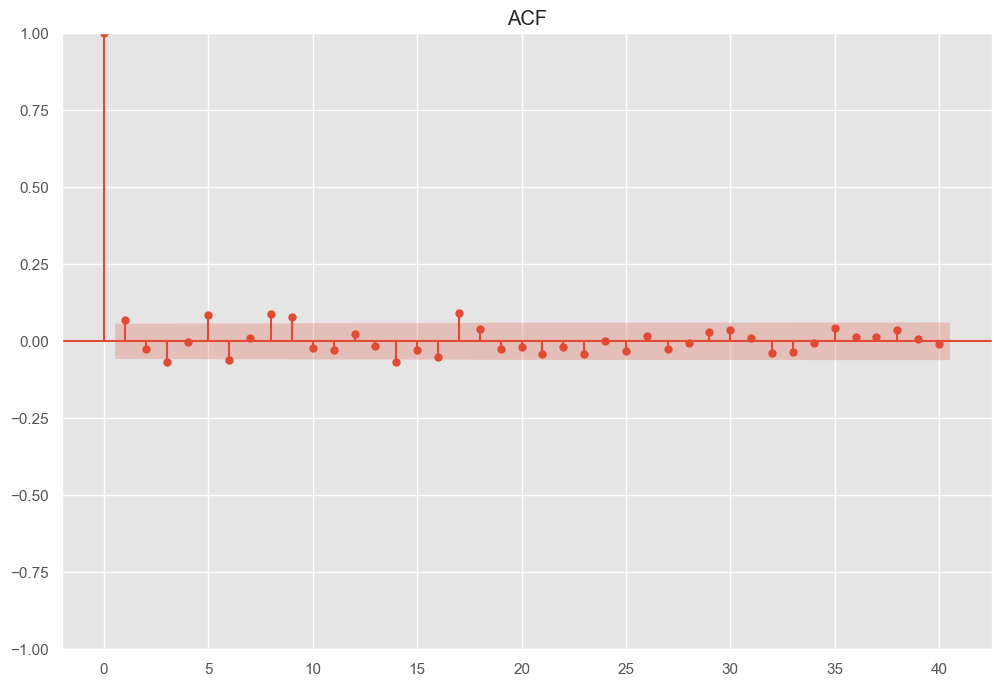

In [14]:
sm.graphics.tsa.plot_acf(food, lags=40)
plt.title('ACF')
plt.show()

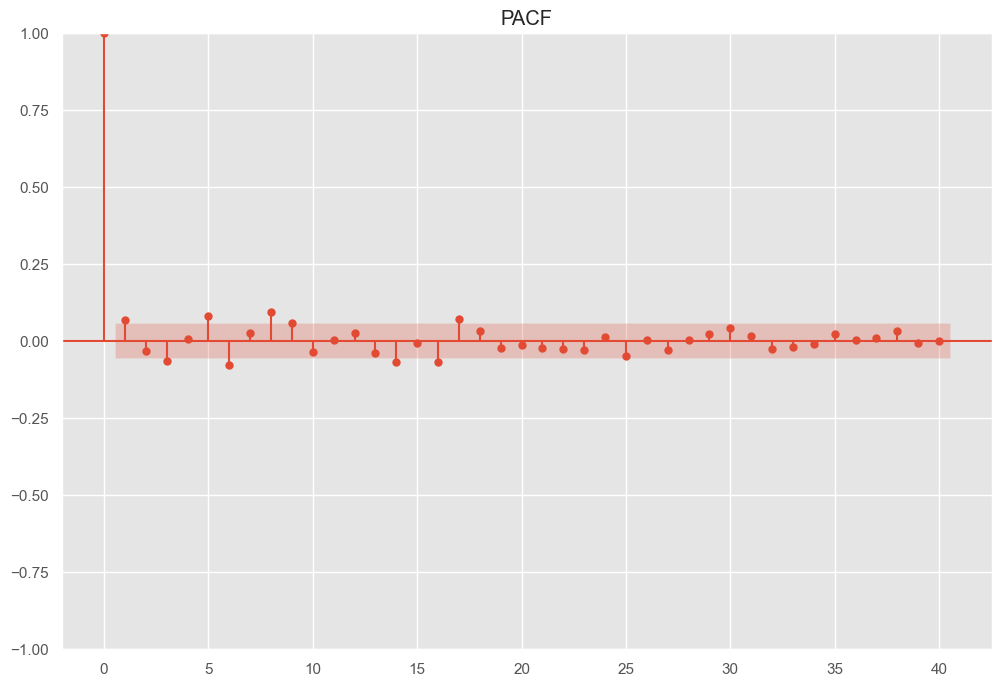

In [15]:
sm.graphics.tsa.plot_pacf(food, lags=40)
plt.title('PACF')
plt.show()

From above, we observe the ACF and PACF both only have a large spike when lag $h=0$. The data indeed looks similar to white noise which is stationary.

However, as we visualize the return plot, we recognize there exists differentiable differences in volatilities in the return. And the fitted Gaussian mixture model also shows different mean and variance at preassumed 3 states level.